<a href="https://colab.research.google.com/github/Nicola-Ibrahim/Pareto-Optimization/blob/main/notebooks/01_pareto_front.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Electric Vehicle Control Optimization

## System Definition
We model an electric vehicle (EV) traveling a fixed distance $D$, where we control its acceleration profile to optimize:
1. **Travel Time ($T$)** - Minimize total trip duration
2. **Energy Consumption ($E$)** - Minimize total energy used

## State Variables
| Variable | Symbol | Description                | Units   |
|----------|--------|----------------------------|---------|
| Position | $x(t)$ | Distance traveled          | meters (m) |
| Velocity | $v(t)$ | Current speed              | m/s     |

## Control Inputs
| Input      | Symbol | Description                | Bounds  |
|------------|--------|----------------------------|---------|
| Acceleration | $u(t)$ | Motor force command        | $[u_{min}, u_{max}]$ m/s² |

## System Dynamics
The EV's motion is governed by:

\begin{cases}
\dot{x}(t) = v(t) & \text{(Position)} \\
\dot{v}(t) = \frac{u(t)}{m} - \frac{F_{drag}(v) + F_{roll}}{m} & \text{(Velocity)} \\
F_{drag} = \frac{1}{2}\rho C_d A v^2(t) & \text{(Drag force)} \\
F_{roll} = C_r m g & \text{(Rolling resistance)}
\end{cases}

### Initial Conditions
\begin{aligned}
x(0) = 0,\ v(0) = 0
\end{aligned}

### Terminal Condition
\begin{aligned}
x(T) = D \quad \text{(Must reach target distance)}
\end{aligned}

## Optimization Problem Formulation

### Objectives
\begin{aligned}
\min_{u(t)} \mathbf{J} = \begin{bmatrix} T \\ E \end{bmatrix}
\end{aligned}

1. **Travel Time ($T$)**:
\begin{aligned}
   T = \inf \left\{ t \, \big| \, x(t) = D \right\}
   \end{aligned}
   - $D$: Total travel distance  
   - $x(t)$: Position at time $t$

2. **Energy Consumption ($E$)**:
\begin{aligned}
   E(u) = \int_0^T P\big(u(t), v(t)\big) \, dt
   \end{aligned}
   \begin{aligned}
   P(u,v) = \frac{u(t) \cdot v(t)}{\eta} + P_{\text{aux}}
   \end{aligned}
   - $\eta$: Motor efficiency (0 < $\eta$ ≤ 1)  
   - $P_{\text{aux}}$: Constant auxiliary power  
   - $u(t)$: Control input (acceleration/deceleration)  
   - $v(t)$: Velocity
   
### Constraints
1. **Control Limits**:
\begin{aligned}
u_{min} \leq u(t) \leq u_{max}
\end{aligned}

2. **Speed Limit**:
\begin{aligned}
0 \leq v(t) \leq v_{max}
\end{aligned}

3. **Distance Completion**:
\begin{aligned}
x(T) = D
\end{aligned}

## Physical Parameters
| Parameter | Symbol | Value | Description |
|-----------|--------|-------|-------------|
| Vehicle mass | $m$ | 1000 kg | - |
| Drag coefficient | $C_d$ | 0.24 | - |
| Frontal area | $A$ | 2.4 m² | - |
| Rolling coeff. | $C_r$ | 0.008 | - |
| Motor efficiency | $\eta$ | 0.85 | 85% efficient |

## Implementation Notes
- **Discretization**: The continuous control $u(t)$ is parameterized as:
  - $u_1$: Constant acceleration in Phase 1
  - $u_2$: Constant deceleration in Phase 2
- **Numerical Integration**: Trapezoidal rule used for energy calculation
- **Constraints Handling**: Normalized constraints ensure balanced optimization



In [46]:
import numpy as np
from typing import Any
from pathlib import Path
import pickle
import pandas as pd

# Import optimizer modules
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.core.population import Population
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from pymoo.core.result import Result

# Import plotting modules
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots


### EVControl Problem

In [47]:
import numpy as np
from pymoo.core.problem import Problem
from typing import Any, Dict

class EVControlProblem(Problem):
    """
    Electric Vehicle Control Optimization Problem
    Objectives: Minimize travel time (minutes) and energy consumption (kWh)
    Constraints: Speed limit and battery capacity
    """

    def __init__(self) -> None:
        # ===== Vehicle Physical Parameters =====
        self.vehicle_mass_kg = 1000           # Typical mid-size EV weight
        self.air_density_kg_m3 = 1.225        # Sea level air density
        self.drag_coefficient = 0.24          # Streamlined EV shape
        self.frontal_area_m2 = 2.4            # Cross-sectional area
        self.rolling_resistance_coeff = 0.008 # Standard tire coefficient
        self.motor_efficiency = 0.85          # 85% efficient drivetrain
        self.regen_efficiency = 0.70          # 70% energy recovery when braking
        self.auxiliary_power_w = 300          # Lights, AC, electronics draw
        self.max_speed_mps = 30               # ≈108 km/h speed limit
        self.target_distance_km = 1.0         # 1 km test distance
        self.max_energy_kwh = 0.4             # 20% of 2kWh battery capacity

        # Convert km to meters for calculations
        self.target_distance_m = self.target_distance_km * 1000

        # ===== Acceleration Bounds =====
        # 0.3 m/s²: Gentle acceleration (comfortable)
        # 4.0 m/s²: Sport mode (near physical limits)
        accel_bounds = (0.3, 4.0)

        # Initialize optimization problem
        super().__init__(
            n_var=2,            # Two variables: accel/decel rates
            n_obj=2,            # Two objectives: time and energy
            n_constr=2,          # Two constraints: speed and energy
            xl=np.array([accel_bounds[0], accel_bounds[0]]),  # Lower bounds
            xu=np.array([accel_bounds[1], accel_bounds[1]])   # Upper bounds
        )

    def _calculate_resistive_forces(self, velocity: float) -> tuple[float, float]:
        """
        Calculate opposing forces at current velocity
        Returns:
            drag_force: Air resistance force [N]
            rolling_force: Tire friction force [N]
        """
        # Quadratic drag force (increases with velocity^2)
        drag_force = 0.5 * self.air_density_kg_m3 * self.drag_coefficient * \
                    self.frontal_area_m2 * velocity**2

        # Constant rolling resistance
        rolling_force = self.rolling_resistance_coeff * self.vehicle_mass_kg * 9.81

        return drag_force, rolling_force

    def _simulate_motion(self, a1: float, a2: float) -> tuple[float, float, float]:
        """
        Simulate vehicle motion in three phases
        Returns:
            total_time_min: Trip duration [minutes]
            max_velocity: Peak speed reached [m/s]
            distance_traveled: Actual distance covered [m]
        """
        dt = 0.1  # Simulation timestep (0.1s resolution)
        distance_traveled = 0.0
        velocity = 0.0
        total_time = 0.0
        max_velocity = 0.0

        # === Phase 1: Acceleration ===
        while (velocity < self.max_speed_mps and
               distance_traveled < self.target_distance_m):
            velocity += a1 * dt  # Increase speed
            distance_traveled += velocity * dt
            total_time += dt
            max_velocity = max(max_velocity, velocity)

            # Enforce speed limit
            if velocity > self.max_speed_mps:
                velocity = self.max_speed_mps

        # === Phase 2: Cruise at max speed ===
        remaining_distance = self.target_distance_m - distance_traveled
        if remaining_distance > 0:
            cruise_time = remaining_distance / self.max_speed_mps
            total_time += cruise_time
            distance_traveled += remaining_distance

        # === Phase 3: Deceleration ===
        while distance_traveled < self.target_distance_m and velocity > 0:
            velocity -= a2 * dt  # Decrease speed
            velocity = max(velocity, 0)  # Prevent negative velocity
            distance_traveled += velocity * dt
            total_time += dt

        return total_time / 60, max_velocity, distance_traveled  # Convert to minutes

    def _calculate_energy_consumption(self, a1: float, a2: float,
                                    total_time_min: float) -> float:
        """
        Calculate total energy used during trip
        Returns:
            energy_kwh: Total consumption [kWh]
        """
        dt = 0.1  # Simulation timestep
        total_energy_wh = 0.0  # Track in watt-hours for precision
        velocity = 0.0
        distance_traveled = 0.0

        while distance_traveled < self.target_distance_m:
            # === Determine current driving phase ===
            if velocity < self.max_speed_mps:
                phase = "accel"
                accel = a1
            else:
                remaining_distance = self.target_distance_m - distance_traveled
                stop_distance = velocity**2 / (2 * a2)  # Physics: v² = 2as
                if remaining_distance <= stop_distance:
                    phase = "decel"
                    accel = -a2
                else:
                    phase = "cruise"
                    accel = 0

            # === Calculate mechanical power ===
            drag_force, rolling_force = self._calculate_resistive_forces(velocity)

            if phase == "accel":
                # Motoring: Power = Force * Velocity / Efficiency
                tractive_force = self.vehicle_mass_kg * accel
                power = ((tractive_force + drag_force + rolling_force) * velocity) \
                        / self.motor_efficiency
            elif phase == "decel":
                # Regenerative braking: Power = Force * Velocity * Regen Efficiency
                tractive_force = self.vehicle_mass_kg * accel  # Negative
                power = ((tractive_force + drag_force + rolling_force) * velocity) \
                        * self.regen_efficiency
            else:  # Cruise
                # Constant speed: Power = Drag * Velocity / Efficiency
                power = (drag_force + rolling_force) * velocity / self.motor_efficiency

            # === Accumulate energy ===
            # Add auxiliary systems and convert to watt-hours
            total_energy_wh += (power + self.auxiliary_power_w) * dt / 3600

            # === Update vehicle state ===
            velocity += accel * dt
            velocity = max(0, min(velocity, self.max_speed_mps))  # Clamp speed
            distance_traveled += velocity * dt

        return total_energy_wh / 1000  # Convert to kWh

    def _evaluate(self, X: np.ndarray, out: Dict[str, Any], *args, **kwargs) -> None:
        """
        Evaluate candidate solutions
        Inputs:
            X: Array of candidate solutions (each row = [accel, decel])
        Outputs:
            out["F"]: Objective values (time, energy)
            out["G"]: Constraint violations
        """
        trip_times = []
        energy_consumptions = []
        constraint_violations = []

        for a1, a2 in X:
            # === Simulate vehicle motion ===
            trip_time_min, max_vel, final_dist = self._simulate_motion(a1, a2)

            # === Calculate energy usage ===
            energy_kwh = self._calculate_energy_consumption(a1, a2, trip_time_min)

            # === Check constraints ===
            # Speed violation (positive if exceeding limit)
            speed_violation = (max_vel - self.max_speed_mps) / self.max_speed_mps

            # Energy violation (positive if exceeding battery)
            energy_violation = (energy_kwh - self.max_energy_kwh) / self.max_energy_kwh

            # Distance violation (should be zero if trip completed)
            distance_violation = (self.target_distance_m - final_dist) / self.target_distance_m

            # === Store results ===
            trip_times.append(trip_time_min)
            energy_consumptions.append(energy_kwh)

            # Only penalize positive violations (exceeding limits)
            constraint_violations.append([
                max(speed_violation, 0),
                max(energy_violation, 0)
            ])

        # Format outputs for optimization
        out["F"] = np.column_stack([trip_times, energy_consumptions])
        out["G"] = np.array(constraint_violations)

#### Simplified implementation

In [48]:
# class EVControlProblem(Problem):
#     """Simplified EV Control Problem with analytical solutions.

#     Key Assumptions:
#     1. Fixed acceleration/deceleration phases
#     2. Simplified energy calculation using average velocity
#     3. Closed-form time and distance equations
#     """

#     def __init__(self):
#         # Vehicle parameters (SI units)
#         self.m = 1000           # Mass [kg]
#         self.ρ = 1.225          # Air density
#         self.CdA = 0.24 * 2.4   # Combined drag coefficient & area
#         self.Cr = 0.008         # Rolling resistance
#         self.η = 0.85           # Efficiency
#         self.D = 1000           # Total distance [m]
#         self.v_max = 30         # Speed limit [m/s]

#         # Bounds for acceleration commands [m/s²]
#         super().__init__(n_var=2, n_obj=2, n_constr=1,
#                          xl=[0.3, 0.3], xu=[4.0, 4.0])

#     def _calculate_time_energy(self, a1: float, a2: float) -> tuple:
#         """Analytical solution for time and energy"""
#         # Phase 1: Acceleration to v_max or natural limit
#         t1 = min(np.sqrt(2*(self.D/2)/a1), self.v_max/a1)
#         d1 = 0.5 * a1 * t1**2
#         v1 = a1 * t1

#         # Phase 2: Deceleration from v1 to 0
#         t2 = v1 / a2
#         d2 = v1 * t2 - 0.5 * a2 * t2**2

#         # Handle remaining distance if needed
#         if (d1 + d2) < self.D:
#             t3 = (self.D - (d1 + d2)) / self.v_max
#             t_total = t1 + t2 + t3
#             v_peak = self.v_max
#         else:
#             t_total = t1 + t2
#             v_peak = v1

#         # Simplified energy calculation (average force method)
#         F_drag_avg = 0.5 * self.ρ * self.CdA * (0.7*v_peak)**2
#         F_roll = self.Cr * self.m * 9.81
#         energy = ((a1*self.m + F_drag_avg + F_roll)*d1/self.η +
#                  (F_drag_avg + F_roll)*self.D) / 3.6e6  # kWh

#         return t_total, energy, v_peak

#     def _evaluate(self, X, out, *args, **kwargs):
#         F, G = [], []
#         for a1, a2 in X:
#             t, e, v = self._calculate_time_energy(a1, a2)
#             F.append([t, e])
#             G.append([(v - self.v_max)/self.v_max])  # Speed constraint

#         out["F"] = np.array(F)
#         out["G"] = np.array(G)

## NSGA-II Optimization Progress Metrics

### Table Column Definitions
| Column        | Description                                                                 | Interpretation                                                                 |
|---------------|-----------------------------------------------------------------------------|--------------------------------------------------------------------------------|
| **`n_gen`**   | Current generation number                                                   | Tracks optimization progress (1 → N)                                           |
| **`n_eval`**  | Cumulative function evaluations                                             | Total objective function calls (time + energy calculations)                    |
| **`n_nds`**   | Non-dominated solutions in population                                       | Count of Pareto-optimal solutions found                                        |
| **`cv_min`**  | Minimum constraint violation                                                | `0.0` = feasible solution exists                                               |
| **`cv_avg`**  | Average constraint violation across population                              | Lower values → better feasibility                                              |
| **`eps`**     | Generational improvement (ε-progress)                                       | Measures movement of Pareto front                                              |
| **`indicator`**| Reference point for ε calculation                                          | Shows what drove improvement                                                   |

### Key Metric Details
#### Constraint Violations (`cv_min`, `cv_avg`)
- **`0.000000E+00`**: Perfect feasibility (all constraints satisfied)
- **Decreasing values**: Population is becoming more feasible
- **Example**: `cv_avg=0.565` → Average solution violates constraints by ~56.5%

#### Pareto Front Progress (`eps`)
| Value Range    | Interpretation                          | Example           |
|----------------|----------------------------------------|-------------------|
| **`0.01-0.1`** | Good improvement                       | `0.056` (Gen 4)  |
| **`<0.01`**    | Convergence                            | `0.001`          |
| **`-`**        | No comparison (first generation)       | Gen 1            |

#### Improvement Indicators
| Indicator  | Meaning                                                                 | When It Appears               |
|------------|-------------------------------------------------------------------------|-------------------------------|
| `ideal`    | Progress toward best possible values                                   | Early optimization (Gens 2-4) |
| `nadir`    | Progress away from worst-case values                                   | Late-stage refinement         |
| `f`        | General front movement (mixed criteria)                                | Middle phases                 |

### Your Optimization Status
1. **Feasibility Achieved**: `cv_min=0.0` since Gen 1 → Valid solutions exist  
2. **Rapid Improvement**: Large `eps` drops (0.166 → 0.056) → Effective exploration  
3. **Pareto Growth**: `n_nds` increasing (4 → 63) → Discovering more optimal solutions  
4. **Ideal-Driven**: Early `indicator=ideal` → Focusing on best potential outcomes

In [49]:
# Create and solve problem
problem: EVControlProblem = EVControlProblem()


# Optimization setup with tuned operators
algorithm: NSGA2 = NSGA2(
        pop_size=200,
        sampling=FloatRandomSampling(),
        crossover=SBX(prob=0.9, eta=15),
        mutation=PolynomialMutation(prob=0.2, eta=20),
        eliminate_duplicates=True
    )

result = minimize(
    problem=problem,
    algorithm=algorithm,
    termination=('n_gen', 23),
    seed=42,
    save_history=True,
    verbose=True
)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      200 |     11 |  0.000000E+00 |  0.0334238672 |             - |             -
     2 |      400 |     26 |  0.000000E+00 |  0.0009131813 |  0.0191231604 |             f
     3 |      600 |     60 |  0.000000E+00 |  0.0002074721 |  0.1162790698 |         ideal
     4 |      800 |    111 |  0.000000E+00 |  0.000000E+00 |  0.0231156449 |         ideal
     5 |     1000 |    138 |  0.000000E+00 |  0.000000E+00 |  0.0400484292 |         ideal
     6 |     1200 |    170 |  0.000000E+00 |  0.000000E+00 |  0.0258558104 |         ideal
     7 |     1400 |    200 |  0.000000E+00 |  0.000000E+00 |  0.0129164042 |         ideal
     8 |     1600 |    200 |  0.000000E+00 |  0.000000E+00 |  0.0007398948 |             f
     9 |     1800 |    200 |  0.000000E+00 |  0.000000E+00 |  0.0066666667 |         ideal
    10 |     2000 |    200 |  0.000000E+00 |  0.000000E+00 |  0.0002310645 |             f

In [50]:
# Show first 5 pareto-solutions
print(f"Found {len(result.F)} Pareto-optimal solutions in last generation")
print(f"All non-dominated solutions shape: {result.F.shape}")  # e.g., (2000, 2)
print("First 5 solutions (Time, Energy) or Objective values:")
print(result.F[:5])

Found 200 Pareto-optimal solutions in last generation
All non-dominated solutions shape: (200, 2)
First 5 solutions (Time, Energy) or Objective values:
[[1.36       0.16460605]
 [1.11       0.22943044]
 [1.11       0.22943044]
 [1.25833333 0.18626582]
 [1.31       0.17462032]]


## 3. Pareto Front Interpretation
The optimal solutions represent trade-offs:
- **Left Extreme**: Minimum time (aggressive acceleration)
- **Right Extreme**: Minimum energy (gentle acceleration)
- **Middle**: Balanced compromises

The Pareto front $ \mathcal{X}_{\text{Pareto}} $ consists of non-dominated solutions:
\begin{aligned}
\mathcal{X}_{\text{Pareto}} = \left\{ \mathbf{J}_i = [T_i, E_i]^T \, \big| \, \nexists \, \mathbf{J}_j \text{ where } T_j \leq T_i \text{ and } E_j \leq E_i \right\}
\end{aligned}

In [51]:
# Extract non-dominated solutions
F = result.F  # Objective space values (T, E)
X = result.X  # Decision variables

# Filter non-dominated solutions
nds_indices = NonDominatedSorting().do(F)
pareto_front = F[nds_indices].reshape(200, 2)

print(f"Found {pareto_front.shape[0]} Pareto-optimal solutions.")


Found 200 Pareto-optimal solutions.


### Visualize problem bounds

In [52]:
# Prepare data for visuallization
xl = problem.xl
xu = problem.xu

# First sort the Pareto points by travel time (x-axis)
sorted_front = pareto_front[pareto_front[:, 0].argsort()]




# Create wider subplots with 1 row and 3 columns
fig = make_subplots(rows=1, cols=3,
                    subplot_titles=("Design Space", "Objective Space", "Pareto Front"),
                    horizontal_spacing=0.12,
                    column_widths=[0.3, 0.3, 0.4])

# 1. Design Space Plot (Left)
fig.add_trace(
    go.Scatter(
        x=X[:, 0], y=X[:, 1],
        mode='markers',
        marker=dict(
            size=8,
            color='rgba(255, 100, 100, 0.7)',
            line=dict(width=1, color='DarkRed')
        ),
        name='Design Points',
        hovertemplate="<b>Accel Phase 1</b>: %{x:.2f} m/s²<br><b>Accel Phase 2</b>: %{y:.2f} m/s²<extra></extra>"
    ),
    row=1, col=1
)

# 2. Objective Space Plot (Middle)
fig.add_trace(
    go.Scatter(
        x=F[:, 0], y=F[:, 1],
        mode='markers',
        marker=dict(
            size=8,
            color='rgba(100, 100, 255, 0.6)',
            line=dict(width=1, color='DarkBlue')
        ),
        name='All Solutions',
        hovertemplate="<b>Time</b>: %{x:.2f} s<br><b>Energy</b>: %{y:.4f} kWh<extra></extra>"
    ),
    row=1, col=2
)

# 3. Pareto Front Plot (Right) - Without connecting lines


fig.add_trace(
    go.Scatter(
        x=pareto_front[:, 0],
        y=pareto_front[:, 1],
        mode='markers',
        marker=dict(
            size=8,
            color='rgba(50, 200, 50, 0.8)',
            opacity=0.5,
            line=dict(width=1, color='DarkGreen')
        ),
        name='Pareto Front',
        hovertemplate="<b>Time</b>: %{x:.2f} s<br><b>Energy</b>: %{y:.4f} kWh<extra></extra>"
    ),
    row=1, col=3
)

# Add smooth trend line (NEW)
fig.add_trace(
    go.Scatter(
        x=sorted_front[:, 0],
        y=sorted_front[:, 1],
        mode='lines',
        line=dict(
            color='black',
            width=3,
            shape='spline',
            smoothing=0.5
        ),
        name='Pareto Frontier',
        hoverinfo='skip',
        opacity=0.5
    ),
    row=1, col=3
)


# Update layout for all subplots
fig.update_layout(
    title_text="EV Control Optimization Results",
    title_x=0.5,
    title_font=dict(size=20),
    showlegend=False,
    width=1400,
    height=550,
    margin=dict(l=60, r=60, b=80, t=100),
    plot_bgcolor='rgba(248,248,255,1)',
    paper_bgcolor='rgba(248,248,255,1)'
)

# Customize axes for all subplots
for col in [1, 2, 3]:
    fig.update_xaxes(
        showgrid=True,
        gridcolor='rgba(200,200,200,0.5)',
        zerolinecolor='lightgrey',
        row=1, col=col
    )
    fig.update_yaxes(
        showgrid=True,
        gridcolor='rgba(200,200,200,0.5)',
        zerolinecolor='lightgrey',
        row=1, col=col
    )

# Specific axis titles
fig.update_xaxes(title_text="Acceleration Phase 1 (m/s²)", row=1, col=1)
fig.update_yaxes(title_text="Acceleration Phase 2 (m/s²)", row=1, col=1)
fig.update_xaxes(title_text="Travel Time (s)", row=1, col=2)
fig.update_yaxes(title_text="Energy Consumption (kWh)", row=1, col=2)
fig.update_xaxes(title_text="Travel Time (s)", row=1, col=3)
fig.update_yaxes(title_text="Energy Consumption (kWh)", row=1, col=3)


# Add colorbar-like legend using annotations
fig.add_annotation(
    x=0.15, y=0.02,
    xref="paper", yref="paper",
    text="● Design Parameters",
    showarrow=False,
    font=dict(color='darkred')
)
fig.add_annotation(
    x=0.45, y=0.02,
    xref="paper", yref="paper",
    text="● All Solutions",
    showarrow=False,
    font=dict(color='darkblue')
)
fig.add_annotation(
    x=0.78, y=0.02,
    xref="paper", yref="paper",
    text="◆ Pareto Front",
    showarrow=False,
    font=dict(color='darkgreen')
)

fig.show()

### Visualize the Pareto Front


In [53]:
# Prepare data
all_F = []
for algo in result.history:
    all_F.extend([ind.F for ind in algo.pop])
all_F = np.array(all_F)

# Identify non-dominated solutions
nds = NonDominatedSorting()
fronts = nds.do(all_F, only_non_dominated_front=False)
pareto_mask = np.zeros(len(all_F), dtype=bool)
pareto_mask[fronts[0]] = True

# Create figure
fig = go.Figure()

# Add traces with custom hover text
fig.add_trace(
    go.Scatter(
        x=all_F[~pareto_mask, 0],
        y=all_F[~pareto_mask, 1],
        mode='markers',
        name='Dominated Solutions',
        marker=dict(
            color='lightgray',
            size=6,
            opacity=0.4,
            line=dict(width=0)
        ),
        hovertemplate="<b>Time</b>: %{x:.2f}s<br><b>Energy</b>: %{y:.2f}kWh<extra></extra>"
    )
)

fig.add_trace(
    go.Scatter(
        x=all_F[pareto_mask, 0],
        y=all_F[pareto_mask, 1],
        mode='markers',
        name='Historical Pareto Front',
        marker=dict(
            color='blue',
            size=8,
            opacity=0.7,
            line=dict(width=0)
        ),
        hovertemplate="<b>Time</b>: %{x:.2f}s<br><b>Energy</b>: %{y:.2f}kWh<extra></extra>"
    )
)

if result.F.size > 0:
    fig.add_trace(
        go.Scatter(
            x=result.F[:, 0],
            y=result.F[:, 1],
            mode='markers',
            name='Final Pareto Front',
            marker=dict(
                color='red',
                size=4,
                opacity=1,
                line=dict(color='black', width=1)
            ),
            hovertemplate="<b>Time</b>: %{x:.2f}s<br><b>Energy</b>: %{y:.2f}kWh<extra></extra>"
        )
    )

# Update layout
fig.update_layout(
    title='Evolution of Solutions with Dominated and Non-Dominated Points',
    title_x=0.5,
    title_font=dict(size=24),
    xaxis_title='Travel Time [s]',
    yaxis_title='Energy Consumption [kWh]',
    legend_title='Solution Types',
    width=1000,
    height=600,
    plot_bgcolor='white',
    paper_bgcolor='white',
    hovermode='closest',
    xaxis=dict(
        gridcolor='lightgray',
        zerolinecolor='lightgray',
        showline=True,
        linewidth=2,
        linecolor='black'
    ),
    yaxis=dict(
        gridcolor='lightgray',
        zerolinecolor='lightgray',
        showline=True,
        linewidth=2,
        linecolor='black'
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1,
        bgcolor='rgba(255,255,255,0.8)'
    )
)

# Add annotations for extreme points
if result.F.size > 0:
    min_time_idx = np.argmin(result.F[:, 0])
    min_energy_idx = np.argmin(result.F[:, 1])

    fig.add_annotation(
        x=result.F[min_time_idx, 0],
        y=result.F[min_time_idx, 1],
        text="Min Time",
        showarrow=True,
        arrowhead=1,
        ax=-50,
        ay=-40
    )

    fig.add_annotation(
        x=result.F[min_energy_idx, 0],
        y=result.F[min_energy_idx, 1],
        text="Min Energy",
        showarrow=True,
        arrowhead=1,
        ax=50,
        ay=40
    )

fig.show()

### Running metric

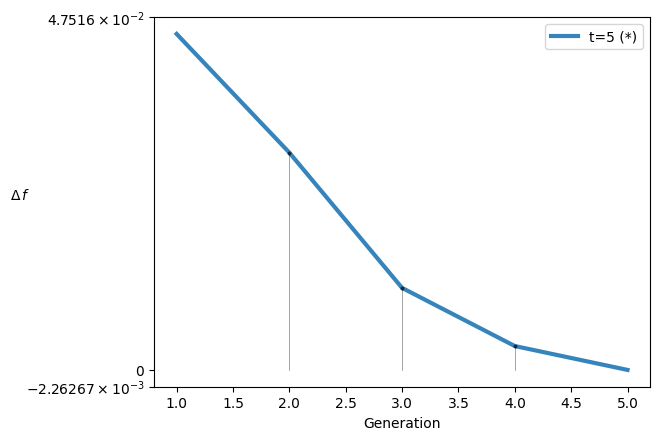

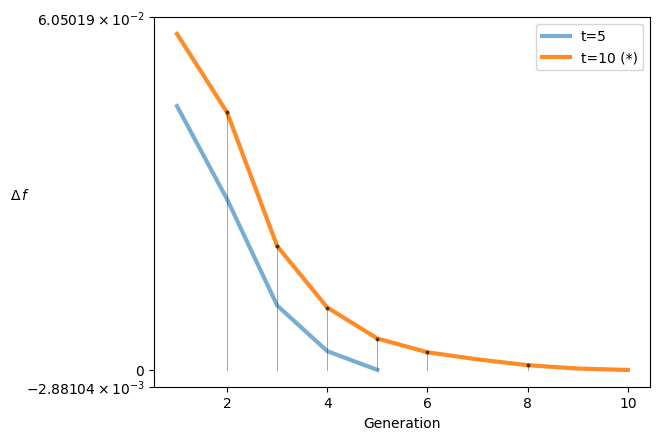

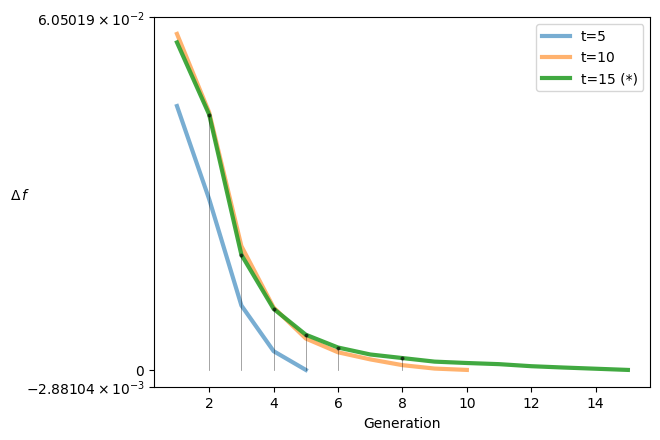

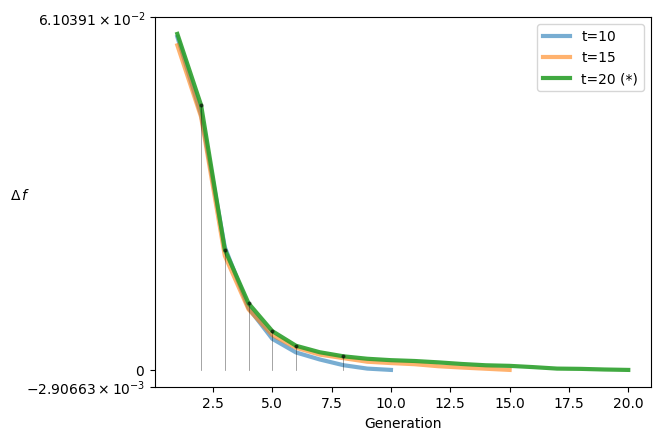

In [54]:
from pymoo.util.running_metric import RunningMetricAnimation

running = RunningMetricAnimation(delta_gen=5,
                        n_plots=3,
                        key_press=False,
                        do_show=True)

for algorithm in result.history:
    running.update(algorithm)


### Results

In [55]:
root_dir = Path(__name__).parent.resolve()

def save_pareto_results(result, save_dir=root_dir / "pareto_results"):
    """Save Pareto front solutions using pandas pickle format"""
    save_dir = Path(save_dir)
    save_dir.mkdir(exist_ok=True, parents=True)

    # Create DataFrame with all data
    df = pd.DataFrame({
        "accel_phase1": result.X[:, 0],
        "accel_phase2": result.X[:, 1],
        "travel_time_min": result.F[:, 0],
        "energy_consumption_kWh": result.F[:, 1],
    })

    # Save using pandas to_pickle (most efficient)
    df.to_pickle(save_dir / "pareto_data.pkl", protocol=pickle.HIGHEST_PROTOCOL)

    print(f"Saved {len(result.F)} solutions to: {save_dir/'pareto_data.pkl'}")




save_pareto_results(result)

Saved 200 solutions to: /content/pareto_results/pareto_data.pkl
